# How to apply LSTM using PyTorch
https://cnvrg.io/pytorch-lstm/

Import

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Load data

In [2]:
df = pd.read_csv('insect_data.csv')
df.head(5)

,# Sensor,Insect
0,1443,0
1,1443,0
2,1443,0
3,1442,0
4,1443,0


array([<AxesSubplot:>], dtype=object)

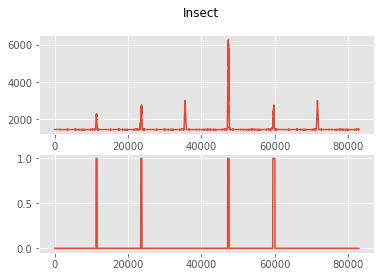

In [3]:
plt.style.use('ggplot')
fig, axes = plt.subplots(nrows=2, ncols=1)
#plt.figure
#plt.subplot()
df['# Sensor'].plot(ax=axes[0], subplots=True, title='Sensor')
#plt.subplot()
df['Insect'].plot(subplots=True, title='Insect')

Data-preprocessing. Get the data and the labels separate from a single dataframe.

In [4]:
X = df.iloc[:, :-1]
y = df.iloc[:, 1:2]

In [5]:
X.head(5)

,# Sensor
0,1443
1,1443
2,1443
3,1442
4,1443


In [6]:
y.head(5)

,Insect
0,0
1,0
2,0
3,0
4,0


Transform and scale output

In [7]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
mm = MinMaxScaler()
ss = StandardScaler()

X_ss = ss.fit_transform(X)
y_mm = mm.fit_transform(y)

Define training and test data

In [8]:
#first 200 for training
n_train = 55000

X_train = X_ss[:n_train, :]
X_test = X_ss[n_train:, :]

y_train = y_mm[:n_train, :]
y_test = y_mm[n_train:, :] 

In [9]:
print("Training Shape", X_train.shape, y_train.shape)
print("Testing Shape", X_test.shape, y_test.shape) 

Training Shape (55000, 1) (55000, 1)
Testing Shape (28000, 1) (28000, 1)


Import pytorch

In [10]:
import torch #pytorch
import torch.nn as nn
from torch.autograd import Variable

Convert numpy arrays to tensors and variables

In [11]:
X_train_tensors = Variable(torch.Tensor(X_train))
X_test_tensors = Variable(torch.Tensor(X_test))

y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors = Variable(torch.Tensor(y_test))

Prepare input for LSTM

In [12]:
#reshaping to rows, timestamps, features

X_train_tensors_final = torch.reshape(X_train_tensors,   (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))
X_test_tensors_final = torch.reshape(X_test_tensors,  (X_test_tensors.shape[0], 1, X_test_tensors.shape[1])) 

In [13]:
print("Training Shape", X_train_tensors_final.shape, y_train_tensors.shape)
print("Testing Shape", X_test_tensors_final.shape, y_test_tensors.shape)

Training Shape torch.Size([55000, 1, 1]) torch.Size([55000, 1])
Testing Shape torch.Size([28000, 1, 1]) torch.Size([28000, 1])


# Define model

In [14]:
class LSTM1(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(LSTM1, self).__init__()
        self.num_classes = num_classes #number of classes
        self.num_layers = num_layers #number of layers
        self.input_size = input_size #input size
        self.hidden_size = hidden_size #hidden state
        self.seq_length = seq_length #sequence length

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True) #lstm
        self.fc_1 =  nn.Linear(hidden_size, 128) #fully connected 1
        self.fc = nn.Linear(128, num_classes) #fully connected last layer

        self.relu = nn.ReLU()
    
    def forward(self,x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #hidden state
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #internal state
        # Propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) #lstm with input, hidden, and internal state
        hn = hn.view(-1, self.hidden_size) #reshaping the data for Dense layer next
        out = self.relu(hn)
        out = self.fc_1(out) #first Dense
        out = self.relu(out) #relu
        out = self.fc(out) #Final Output
        return out

Hyper parameters

In [15]:
num_epochs = 500 #1000 epochs
learning_rate = 0.001 #0.001 lr

input_size = 1 #number of features
hidden_size = 40 #number of features in hidden state
num_layers = 1 #number of stacked lstm layers

num_classes = 1 #number of output classes

 Instantiate the class LSTM1 object

In [16]:
lstm1 = LSTM1(num_classes, input_size, hidden_size, num_layers, X_train_tensors_final.shape[1]) #our lstm class 

In [17]:
print(lstm1)

LSTM1(
  (lstm): LSTM(1, 40, batch_first=True)
  (fc_1): Linear(in_features=40, out_features=128, bias=True)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)


Loss function and optimizer

In [18]:
criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm1.parameters(), lr=learning_rate)

# Train the model

In [19]:
for epoch in range(num_epochs):
  outputs = lstm1.forward(X_train_tensors_final) #forward pass
  optimizer.zero_grad() #caluclate the gradient, manually setting to 0
 
  # obtain the loss function
  loss = criterion(outputs, y_train_tensors)
 
  loss.backward() #calculates the loss of the loss function
 
  optimizer.step() #improve from loss, i.e backprop
  if epoch % 100 == 0:
    print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 0.01793
Epoch: 100, loss: 0.00699
Epoch: 200, loss: 0.00688
Epoch: 300, loss: 0.00670
Epoch: 400, loss: 0.00630


# Run the model

Convert data

In [20]:
df_X_ss = ss.transform(df.iloc[:, :-1]) #old transformers
df_y_mm = mm.transform(df.iloc[:, -1:]) #old transformers

df_X_ss = Variable(torch.Tensor(df_X_ss)) #converting to Tensors
df_y_mm = Variable(torch.Tensor(df_y_mm))
#reshaping the dataset
df_X_ss = torch.reshape(df_X_ss, (df_X_ss.shape[0], 1, df_X_ss.shape[1]))

Show predictions

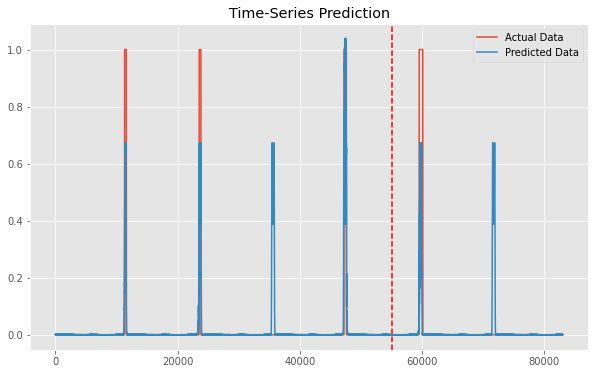

In [21]:
train_predict = lstm1(df_X_ss)#forward pass
data_predict = train_predict.data.numpy() #numpy conversion
dataY_plot = df_y_mm.data.numpy()

data_predict = mm.inverse_transform(data_predict) #reverse transformation
dataY_plot = mm.inverse_transform(dataY_plot)
plt.figure(figsize=(10,6)) #plotting
plt.axvline(x=n_train, c='r', linestyle='--') #size of the training set

plt.plot(dataY_plot, label='Actual Data') #actual plot
plt.plot(data_predict, label='Predicted Data') #predicted plot
plt.title('Time-Series Prediction')
plt.legend()
plt.show()

Real event test

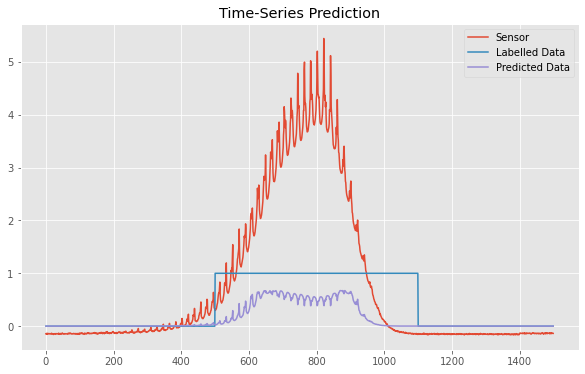

In [22]:
x_start=59000
x_end=60500
plt.figure(figsize=(10,6)) #plotting
plt.plot(X_ss[x_start:x_end], label='Sensor') #actual plot
plt.plot(dataY_plot[x_start:x_end], label='Labelled Data') #actual plot
plt.plot(data_predict[x_start:x_end], label='Predicted Data') #predicted plot
plt.title('Time-Series Prediction')
plt.legend()
plt.show()

Fake event test

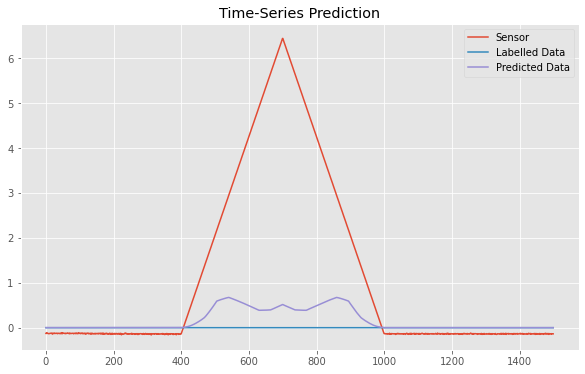

In [23]:
x_start=71000
x_end=72500
plt.figure(figsize=(10,6)) #plotting
plt.plot(X_ss[x_start:x_end], label='Sensor') #actual plot
plt.plot(dataY_plot[x_start:x_end], label='Labelled Data') #actual plot
plt.plot(data_predict[x_start:x_end], label='Predicted Data') #predicted plot
plt.title('Time-Series Prediction')
plt.legend()
plt.show()